# Turn-by-turn bunch analysis

In [1]:
import os
import pickle
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proplot as pplt
import scipy.fft
from tqdm.notebook import trange
from ipywidgets import interact
from ipywidgets import widgets

sys.path.append("/home/46h/repo/psdist/")
import psdist as ps
import psdist.visualization as psv

from tunes import compute_tunes_phase_diff
from tunes import compute_tunes_fft
from tunes import fft

In [2]:
pplt.rc["colorbar.width"] = "1.2em"
pplt.rc["cmap.discrete"] = False
pplt.rc["cmap.sequential"] = "viridis"
pplt.rc["cycle"] = "538"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["grid"] = False

In [3]:
save = False

## Load data 

In [4]:
timestamp = 230922142917
datadir = f"../../data_output/sns_ring/track_bunch/{timestamp}/"    
os.listdir(datadir)

['track_bunch.py',
 'log.txt',
 'lattice_params.pkl',
 'lattice_twiss.dat',
 'lattice_dispersion.dat',
 'lattice_params_4d.pkl',
 'lattice_twiss_4d.dat',
 'history.dat',
 'bunch_00000.dat',
 'bunch_00100.dat',
 'bunch_00199.dat']

In [5]:
if save:
    outdir = f"../../figures/sns_ring/track_bunch/{timestamp}/"
    if not os.path.isdir(outdir):
        os.makedirs(outdir)

def save_figure(filename):
    if not save:
        return
    filename = os.path.join(outdir, filename)
    plt.savefig(filename)

## Linear lattice analysis 

### Transfer matrix

In [6]:
file = open(os.path.join(datadir, "lattice_params_4d.pkl"), "rb")
lattice_params_4d = pickle.load(file, encoding="latin1")
file.close()

pprint(lattice_params_4d)

{'M': array([[ 1.45331628e-01,  1.00778025e+01,  1.17849764e-22,
         3.08853026e-21,  0.00000000e+00, -1.30852575e-01,
         0.00000000e+00],
       [-9.91925249e-02,  2.45865822e-03, -2.49160030e-23,
         8.83766805e-23,  0.00000000e+00, -5.03920040e-03,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  6.01133085e-01,
         9.97167735e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -6.43947112e-02,
         5.95336916e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.68906336e-02,  6.21604384e-02, -1.19435442e-23,
         1.41237211e-22,  1.00000000e+00,  5.12848776e+01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.0

### Position-dependent parameters

These might be wrong.... they were computed by analyzing the transfer matrix starting from each node, rather than propagating the Twiss parameters along the beamline.

In [7]:
filename = os.path.join(datadir, "lattice_twiss_4d.dat")
twiss_4d = pd.read_table(filename, sep=" ", index_col=0)
twiss_4d.head()

,s,beta_1x,beta_1y,beta_2x,beta_2y,alpha_1x,alpha_1y,alpha_2x,alpha_2y,u,nu1,nu2
0,0.000000,10.105431,0.0,2.748485e-42,12.444053,0.071632,-0.0,5.936704e-42,0.003617,0.000000e+00,-0.0,-1.523558
1,0.883004,10.056479,0.0,2.729211e-42,12.500323,-0.016195,-0.0,-3.985292e-15,-0.067342,1.110223e-16,-0.0,-1.542946
2,1.378195,10.090806,0.0,2.736287e-42,12.586723,-0.054441,-0.0,1.675597e-41,-0.107136,0.000000e+00,-0.0,-1.554128
3,1.873387,10.164280,0.0,2.754905e-42,12.712534,-0.093911,-0.0,-2.058484e-14,-0.146930,1.110223e-16,-0.0,-1.565403
4,2.963570,10.533009,0.0,2.854886e-42,13.128405,-0.223448,-0.0,5.844454e-15,-0.234538,1.110223e-16,-0.0,-1.589790


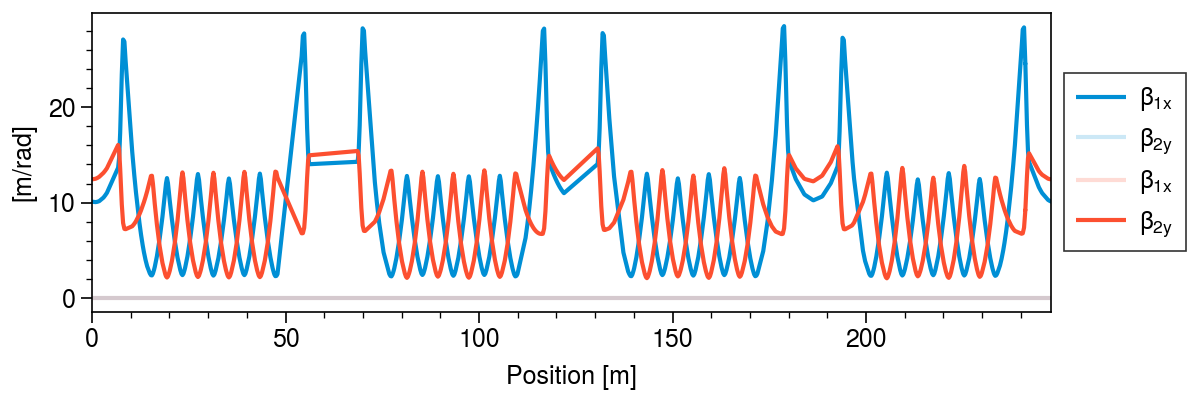

In [8]:
fig, ax = pplt.subplots(figsize=(6, 2))
_colors = pplt.Cycle("538").by_key()["color"]
ax.plot(twiss_4d["s"], twiss_4d["beta_1x"], label=r"$\beta_{1x}$", color=_colors[0])
ax.plot(twiss_4d["s"], twiss_4d["beta_1y"], label=r"$\beta_{2y}$", color=_colors[0], alpha=0.2)
ax.plot(twiss_4d["s"], twiss_4d["beta_2x"], label=r"$\beta_{1x}$", color=_colors[1], alpha=0.2)
ax.plot(twiss_4d["s"], twiss_4d["beta_2y"], label=r"$\beta_{2y}$", color=_colors[1])
ax.legend(loc="right", ncols=1)
ax.format(xlabel="Position [m]", ylabel="[m/rad]")
save_figure("twiss_4d")
plt.show()

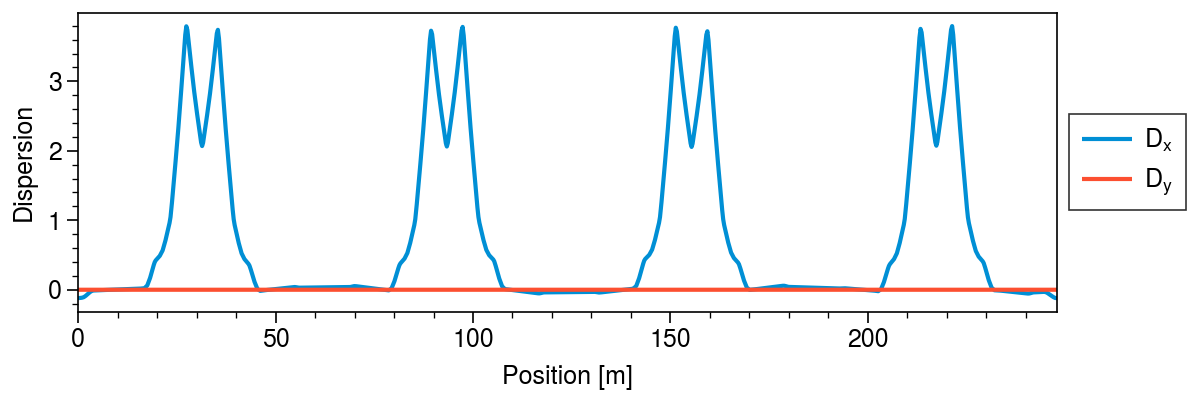

In [9]:
filename = os.path.join(datadir, "lattice_dispersion.dat")
dispersion = pd.read_table(filename, sep=" ", index_col=0)

fig, ax = pplt.subplots(figsize=(6, 2))
ax.plot(dispersion["s"], dispersion["disp_x"], label=r"$D_x$")
ax.plot(dispersion["s"], dispersion["disp_y"], label=r"$D_y$")
ax.legend(loc="right", ncols=1)
ax.format(xlabel="Position [m]", ylabel="Dispersion")
save_figure("dispersion")
plt.show()

## Scalar history 

In [10]:
history = pd.read_csv(os.path.join(datadir, "history.dat"))
history.columns

Index(['eps_x', 'y_rms', 'cov_1-1', 'energy', 'cov_1-3', 'cov_1-4', 'cov_3-3',
       'eps_y', 'n_parts', 'z_rms', 'cov_3-4', 'cov_0-5', 'cov_4-5', 'cov_0-4',
       'z_max', 'cov_1-5', 'cov_5-5', 'cov_1-2', 'cov_0-0', 'cov_3-5', 'y_min',
       'eps_2', 'cov_2-5', 'eps_1', 'x_rms', 'cov_4-4', 'x_min', 'z_min',
       'x_max', 'cov_2-4', 'y_max', 'beta', 'cov_2-3', 'cov_2-2', 'cov_0-1',
       'gamma', 'cov_0-3', 'cov_0-2', 'mean_4', 'mean_5', 'mean_0', 'mean_1',
       'mean_2', 'mean_'],
      dtype='object')

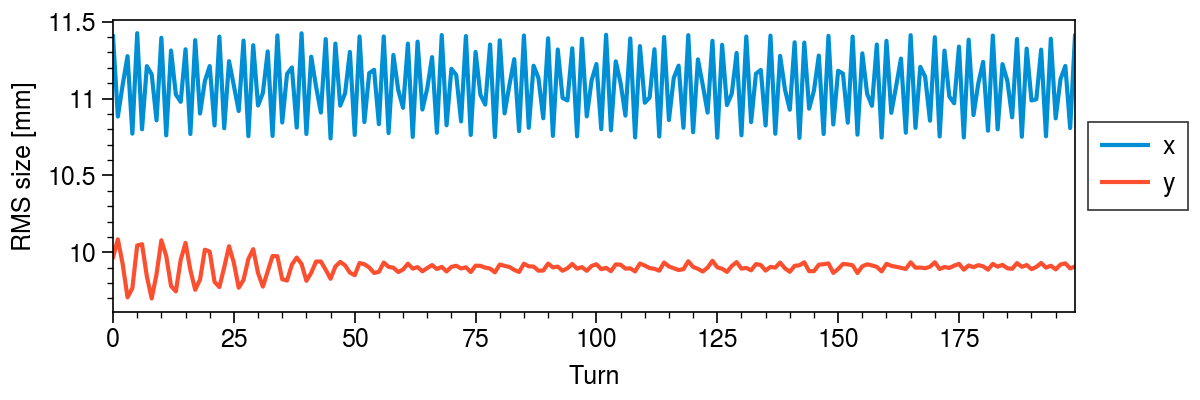

In [11]:
fig, ax = pplt.subplots(figsize=(6, 2))
ax.plot(1000.0 * history.loc[:, "x_rms"].values, label="x")
ax.plot(1000.0 * history.loc[:, "y_rms"].values, label="y")
ax.format(xlabel="Turn", ylabel="RMS size [mm]")
ax.legend(loc="r", ncols=1)
save_figure("rms")
plt.show()

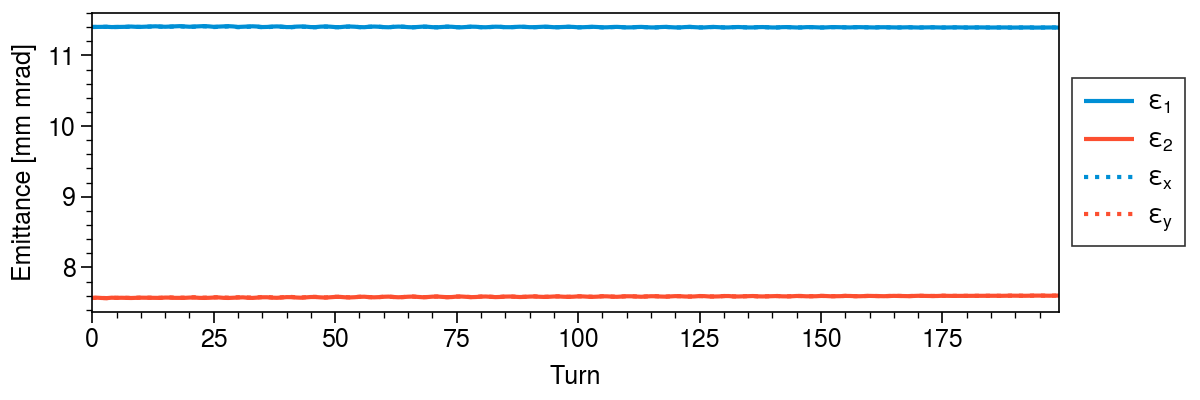

In [12]:
colors = pplt.Cycle("538").by_key()["color"]

fig, ax = pplt.subplots(figsize=(6, 2))
ax.plot(1.00e+06 * history.loc[:, "eps_1"].values, label=r"$\varepsilon_1$", color=colors[0], ls="-")
ax.plot(1.00e+06 * history.loc[:, "eps_2"].values, label=r"$\varepsilon_2$", color=colors[1], ls="-")
ax.plot(1.00e+06 * history.loc[:, "eps_x"].values, label=r"$\varepsilon_x$", color=colors[0], ls=":")
ax.plot(1.00e+06 * history.loc[:, "eps_y"].values, label=r"$\varepsilon_y$", color=colors[1], ls=":")
ax.format(xlabel="Turn", ylabel="Emittance [mm mrad]")
ax.legend(loc="r", ncols=1)
save_figure("emittance")
plt.show()

## Tunes

A small number of particles were saved at every turn.

In [ ]:
filenames = os.listdir(datadir)
filenames = [f for f in filenames if f.startswith("smallbunch")]
filenames = sorted(filenames)
filenames = [os.path.join(datadir, f) for f in filenames]

smallbunches = []
for filename in filenames:
    X = np.load(filename)
    X[:, :4] *= 1000.0  # [m, rad] -> [mm, mrad]
    X[:, 5] *= 1000.0  # [GeV] -> [MeV]
    smallbunches.append(X)
smallbunches = np.array(smallbunches)
smallbunches.shape

### TBT phase difference

Normalized the bunch coordinates using the lattice Twiss parameters. Ignore dispersion.

In [ ]:
V = np.copy(lattice_params_4d["V"])
Vinv = np.linalg.inv(V)

smallbunches_n = np.zeros(smallbunches.shape)
for i in range(smallbunches_n.shape[0]):
    smallbunches_n[i, :, :4] = ps.cloud.transform_linear(smallbunches[i, :, :4], Vinv)

In [ ]:
widget = psv.cloud.proj2d_interactive_slice(
    data=list(smallbunches_n[:, :, :4]),
    dims=["x_n", "px_n", "y_n", "py_n"],
    share_limits=2,
    options=dict(ellipse=True),
    rms_ellipse_kws=dict(color="black", level=2.0),
    cmap=pplt.Colormap("mono", left=0.25),
)
display(widget)

Compute the tunes using the turn-by-turn phase difference in $x_n$-$x'_n$ and $y_n$-$y'_n$ phase space.

In [ ]:
turn_start = 0
turn_stop = 50
tunes = compute_tunes_phase_diff(smallbunches_n[turn_start : turn_stop])

In [ ]:
xmin = ymin = 0.0
xmax = ymax = 0.35
limits = [(xmin, xmax), (ymin, ymax)]

fig, ax = pplt.subplots()
psv.cloud.plot2d(
    tunes, 
    ax=ax, 
    kind="scatter",
    # bins=75, limits=limits, colorbar=True,
)
ax.format(xlim=limits[0], ylim=limits[1])
ax.format(xlabel=r"$\nu_1$", ylabel=r"$\nu_2$")
plt.show()

### FFT 

In [ ]:
@interact(
    part=(0, len(smallbunches[0]) - 1),
    norm=False,
    tmax=widgets.IntSlider(min=0, max=len(smallbunches), value=len(smallbunches)),
)
def update(part, norm, tmax):
    coords = smallbunches_n if norm else smallbunches
    signals = []
    for axis in [0, 2]:
        signal = coords[:, part, axis]
        signals.append(signal)
        
    fig, axs = pplt.subplots(figsize=(9.0, 2.5), nrows=2, ncols=2, spany=False, sharey=False, sharex=False)
    for i, (dim, signal) in enumerate(zip(["x", "y"], signals)):
        freq, amp = fft(signal)
        amp = amp / np.max(amp)
        axs[i, 0].plot(freq, amp, label=dim, color="black")
        axs[i, 1].plot(signal[:tmax], label=dim, color="black")
    axs[0, 0].format(ylabel="Horizontal")
    axs[1, 0].format(ylabel="Vertical")
    axs[1, 0].format(xlabel="Freqency")
    axs[1, 1].format(xlabel="Turn")
    axs[:, 0].format(xlim=(0.0, 0.5), ylim=(-0.02, 1.1))
    plt.show()

In [ ]:
tunes_fft = compute_tunes_fft(smallbunches_n)

In [ ]:
fig, axs = pplt.subplots(ncols=2)
for i, ax in enumerate(axs):
    psv.cloud.plot2d(
        [tunes, tunes_fft][i], ax=ax, 
        kind="scatter",
        # bins=75, limits=limits, colorbar=True,
    )
axs.format(toplabels=["Phase diff", "FFT"])
# axs.format(xlim=limits[0], ylim=limits[1])
axs.format(xlabel=r"$\nu_1$", ylabel=r"$\nu_2$")
save_figure("tune_fft_phase_diff")
plt.show()

## Phase space distribution

In [17]:
filenames = os.listdir(datadir)
filenames = [f for f in filenames if f.startswith("bunch")]
filenames = sorted(filenames)
filenames = [os.path.join(datadir, f) for f in filenames]

bunches = []
for filename in filenames:
    bunch = pd.read_table(filename, comment="%", sep="\s+", index_col=0)    
    # columns = ["x", "xp", "y", "yp", "z", "dE"]
    # if bunch.shape[1] > 6:
    #     columns += ["Jx", "phasex", "nux", "nuy", "Jy", "phasey"]
    # bunch.columns = columns
    # columns = [c for c in columns if c not in ["phasex", "Jx", "phasey", "Jy"]]
    # bunch = bunch.loc[:, columns]
    # bunch.values[:, :4] *= 1000.0  # [m, rad] -> [mm, mrad]
    # bunch.values[:, 5] *= 1000.0  # [GeV] -> [MeV]
    bunches.append(bunch.copy())

In [18]:
widget = psv.cloud.proj2d_interactive_slice(
    data=[bunch.values for bunch in bunches],
    # dims=list(bunch.columns),
    share_limits=2,
    options=dict(ellipse=True, profiles=True),
    rms_ellipse_kws=dict(color="black", level=2.0),
    autolim_kws=dict(pad=0.25),
    # cmap=pplt.Colormap("mono", left=0.05, right=0.9),
    colorbar=True,
    offset=1.0,
)
display(widget)

interactive(children=(BoundedIntText(value=0, description='frame', max=2), Dropdown(description='dim 1', optio…

In [ ]:
for bunch, filename in zip(bunches, filenames):
    turn = int(filename.split("bunch_")[-1].split(".dat")[0])
    grid = psv.CornerGrid(d=4)
    grid.plot_cloud(
        bunch.iloc[:, :4].values,
        bins=50,
        offset=1.0,
    )
    save_figure(f"corner_{turn:05.0f}")
    plt.show()